In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

In [2]:
reviews = pd.read_csv("amazon_reviews.csv")
reviews.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [3]:
# Display dataset shape
print(f"Dataset contains {reviews.shape[0]} rows and {reviews.shape[1]} columns")

Dataset contains 4915 rows and 12 columns


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [5]:
reviews.isnull().sum()

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

In [6]:
# Handle Missing Values
reviews['reviewerName'] = reviews['reviewerName'].fillna('Anonymous')
reviews = reviews.dropna(subset=['reviewText'])


In [7]:
# Convert review time to datetime
reviews['reviewTime'] = pd.to_datetime(reviews['reviewTime'])
reviews['year'] = reviews['reviewTime'].dt.year

In [8]:
# Define Text Cleaning Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization & stopwords removal
    return text

# Apply Text Cleaning
reviews['cleaned_review'] = reviews['reviewText'].apply(clean_text)

In [10]:
# Sentiment Labeling
reviews['sentiment'] = reviews['overall'].apply(lambda x: 2 if x >= 4 else (1 if x == 3 else 0))

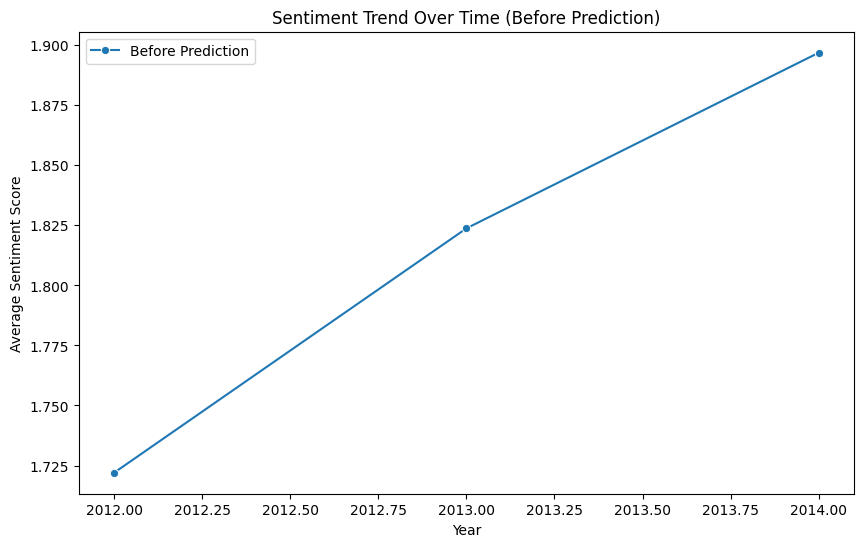

In [11]:
# Data Visualization Before Prediction
# Sentiment Trend Over Time (Before Prediction)
plt.figure(figsize=(10, 6))
sns.lineplot(x=reviews.groupby('year')['sentiment'].mean().index, y=reviews.groupby('year')['sentiment'].mean().values, marker='o', label='Before Prediction')
plt.title('Sentiment Trend Over Time (Before Prediction)')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

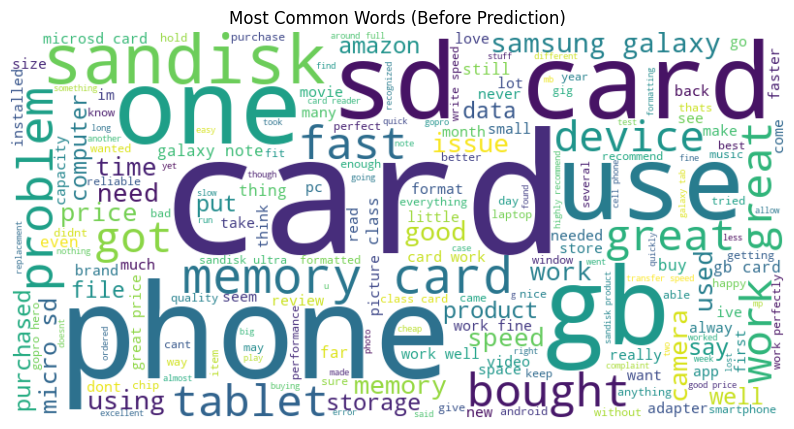

In [12]:
# Word Cloud (Before Prediction)
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(" ".join(reviews['cleaned_review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words (Before Prediction)')
plt.show()

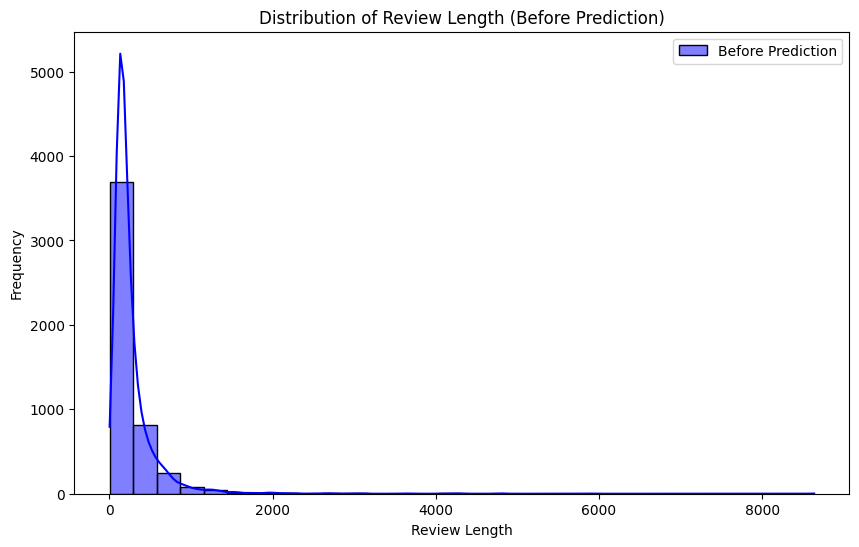

In [13]:
# Review Length Distribution (Before Prediction)
plt.figure(figsize=(10, 6))
sns.histplot(reviews['reviewText'].apply(lambda x: len(str(x))), bins=30, kde=True, color='blue', label='Before Prediction')
plt.title('Distribution of Review Length (Before Prediction)')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [14]:
# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=7000, min_df=3, max_df=0.85, ngram_range=(1,3))
X = vectorizer.fit_transform(reviews['cleaned_review']).toarray()
y = reviews['sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# Apply Undersampling on Overrepresented Class (Positive)
smote = SMOTE(sampling_strategy={0: int(y_train[y_train == 0].shape[0] * 2), 1: int(y_train[y_train == 1].shape[0] * 4)}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [16]:
# Compute Sample Weights
weights = compute_sample_weight(class_weight="balanced", y=y_train_resampled)

# Train XGBoost with Balanced Weights
best_model = xgb.XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    learning_rate=0.02,
    max_depth=7,
    n_estimators=1200,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=5,
    gamma=0.3
)

best_model.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Predictions
y_pred_tuned = best_model.predict(X_test)
reviews['predicted_sentiment'] = best_model.predict(vectorizer.transform(reviews['cleaned_review']).toarray())

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Model Accuracy: {accuracy:.4f}")


Model Accuracy: 0.9237


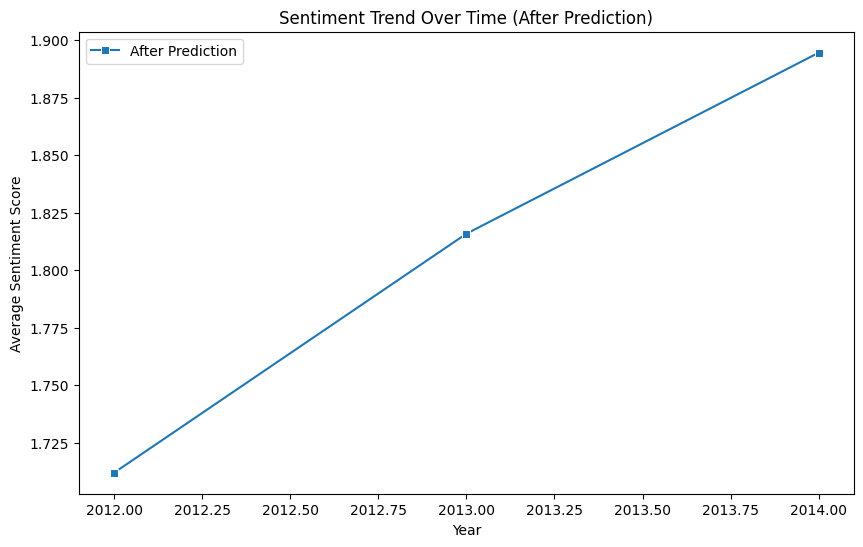

In [17]:
# Data Visualization After Prediction
# Sentiment Trend Over Time (After Prediction)
plt.figure(figsize=(10, 6))
sns.lineplot(x=reviews.groupby('year')['predicted_sentiment'].mean().index, y=reviews.groupby('year')['predicted_sentiment'].mean().values, marker='s', label='After Prediction')
plt.title('Sentiment Trend Over Time (After Prediction)')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()

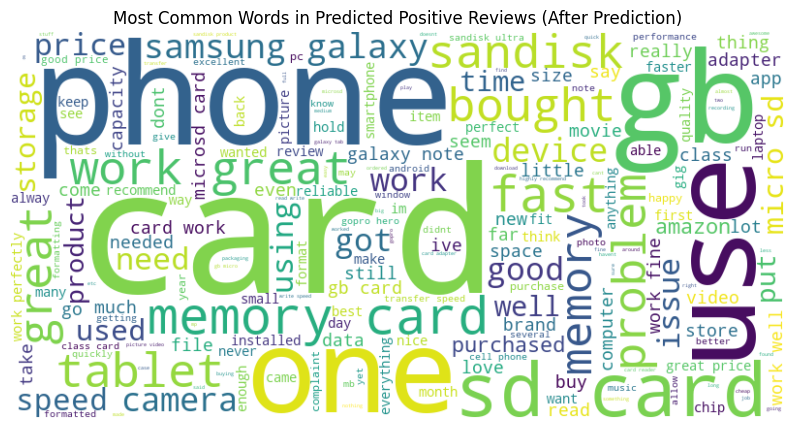

In [18]:
# Word Cloud (After Prediction for Positive Sentiment)
wordcloud_after = WordCloud(width=800, height=400, background_color='white').generate(" ".join(reviews[reviews['predicted_sentiment'] == 2]['cleaned_review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_after, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Predicted Positive Reviews (After Prediction)')
plt.show()

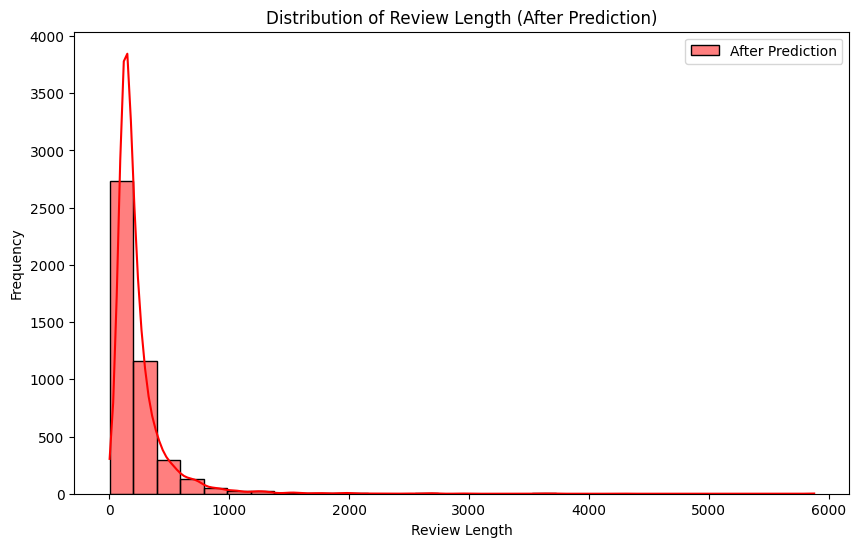

In [19]:
# Review Length Distribution (After Prediction)
plt.figure(figsize=(10, 6))
sns.histplot(reviews[reviews['predicted_sentiment'] == 2]['reviewText'].apply(lambda x: len(str(x))), bins=30, kde=True, color='red', label='After Prediction')
plt.title('Distribution of Review Length (After Prediction)')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()
